In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('cola_dataset/in_domain_train.tsv', delimiter = '\t', header = None, names = ['sentence_source', 'label','label_original','sentence'])
#df.head()

1    6023
0    2528
Name: label, dtype: int64
1    0.704362
0    0.295638
Name: label, dtype: float64


<Axes: title={'center': 'Label Distribution'}>

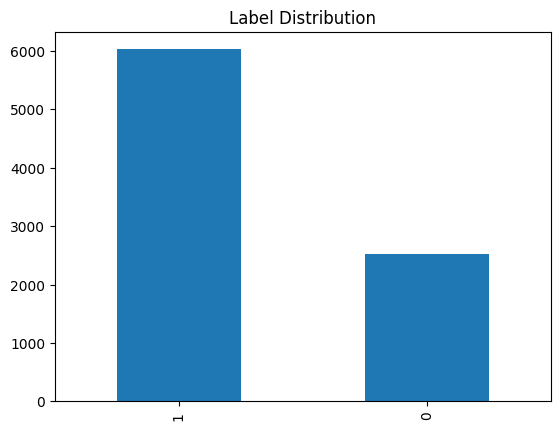

In [ ]:
# Check the distribution of labels
label_dist = df['label'].value_counts()
print(label_dist)

# distribution of labels as percentage
label_dist_percentage = df['label'].value_counts(normalize = True)
print(label_dist_percentage)

# visualize the distribution using a bar plot
label_dist.plot(kind='bar', title='Label Distribution')

There is imbalanced data , so we will resample instances using these:
1. Undersampling (not very relevant here? for presentation can explain that we know it isn't relevant but we wanted to explore it)
2. Oversampling
3. SMOTE

Before resampling, we will split the dataset, and tokenise using TF-IDF Vectorizer **(replace this with whichever tokeniser is better!)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = df['sentence']
y_train = df['label']

# convert sentences into numerical data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# check if tokenizing done correctly
# print(X_train_tfidf)

# check dimension of X_train_tfidf. output = (no. of sentences, no. of unique words/tokens)
print(X_train_tfidf.shape)

(8551, 5361)


### Undersampling

0    2528
1    2528
Name: label, dtype: int64


<Axes: title={'center': 'Label Distribution'}>

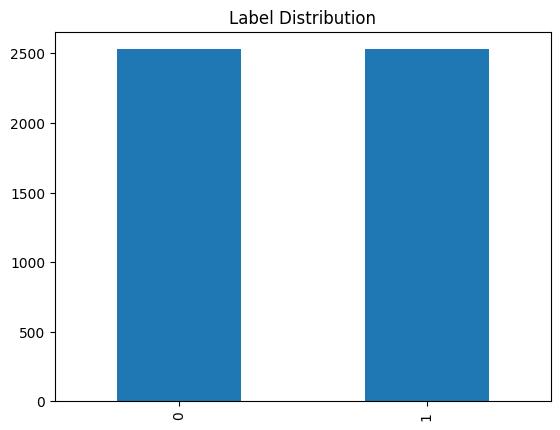

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Perform undersampling with 1:1 class distribution
rus = RandomUnderSampler(sampling_strategy=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train_tfidf, y_train)

# Check the distribution of oversampled labels
y_train_under_dist = y_train_rus.value_counts()
print(y_train_under_dist)

# visualize the distribution using a bar plot
y_train_under_dist.plot(kind='bar', title='Label Distribution after Undersampling')

### Oversampling

1    6023
0    6023
Name: label, dtype: int64


<Axes: title={'center': 'Label Distribution'}>

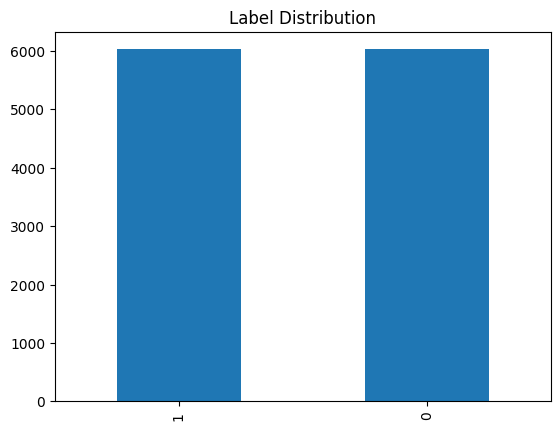

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Perform oversampling with 1:1 class distribution
ros = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

# Check the distribution of oversampled labels
y_train_over_dist = y_train_ros.value_counts()
print(y_train_over_dist)

# visualize the distribution using a bar plot
y_train_over_dist.plot(kind='bar', title='Label Distribution after Oversampling')

In [ ]:
# SMOTE

## **Some questions**:

**Why we need to balance the data?**
If the dataset is highly imbalanced, the model might become insensitive to the minority class (grammatically incorrect sentences). This can lead to many false negatives, where errors are overlooked. In such cases, balancing the dataset can help the model become more sensitive to errors.

**Why we choose SMOTE over oversampling?**
The method used for balancing can also influence the desired balance. For instance, random oversampling can lead to overfitting if the minority class is oversampled too much. Synthetic methods like SMOTE create new examples, which can sometimes introduce noise or artificial patterns.


## **Research on which SMOTE variant to use?**

#### Easy vs. Hard Samples:

- **Easy Samples**: These are data points that are well-separated from the other classes in the feature space. They are located deep within the territory of their respective class and are easy for the model to classify correctly.

- **Hard Samples**: These are data points that are close to the decision boundary or are surrounded by data points from other classes. They are challenging for the model to classify correctly and are often the primary contributors to misclassification errors.

In the context of deep learning and neural networks, hard samples are often the focus during training, especially when techniques like hard negative mining are employed. The idea is to prioritize the difficult samples during training to improve the model's robustness and generalization.

#### SMOTE vs. ADASYN:

- **SMOTE (Synthetic Minority Over-sampling Technique)**:
  - **Description**: SMOTE creates synthetic samples in the feature space. For each minority class sample, it selects 'k' nearest neighbors, chooses one of them randomly, and then creates a random linear combination of these two samples to produce a new synthetic sample.
  - **Advantages**: Adds diversity to the dataset by creating new synthetic examples.
  - **Drawbacks**: Can introduce noise, especially if synthetic samples are generated too far from any real samples.

- **ADASYN (Adaptive Synthetic Sampling)**:
  - **Description**: ADASYN is an extension of SMOTE. It focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier. In other words, it gives more weight to the boundary samples (hard samples) and generates more synthetic data in those regions.
  - **Advantages**: Prioritizes regions where the model is likely to misclassify, making it adaptive to the actual learning difficulty.
  - **Drawbacks**: Can be computationally more intensive than SMOTE.

#### Which to Use for Grammar Acceptability Model?

For a grammar acceptability model, the primary concern is to correctly identify sentences with subtle grammatical errors, which can be considered as "hard samples." Given this:

- **ADASYN** might be more suitable because it focuses on generating synthetic samples in regions of the feature space where the model is more likely to misclassify, i.e., near the hard samples. This can help the model become more sensitive to subtle grammatical errors.

- However, it's essential to be cautious, as generating too many synthetic samples near the decision boundary can introduce noise and make the model overly sensitive, leading to more false positives.

- **SMOTE** can be a good starting point due to its simplicity and effectiveness. If you find that the model struggles with certain types of subtle errors, you can then consider ADASYN.

In practice, the best approach is often to experiment with both techniques and evaluate their performance on a validation set. It's also crucial to ensure that the synthetic samples make sense in the context of grammar acceptability, i.e., they should represent plausible, albeit incorrect, sentence structures.


## **Evaluation Stuff: How to decide which metric?**
Depending on the application, the cost of false positives and false negatives might differ. For instance, in a learning environment, overlooking errors (false negatives) might be more detrimental than occasionally flagging correct sentences. This cost consideration can influence the desired balance.

FP: wrong, mark correct
FN: correct, mark wrong

**In grammatical acceptability, we rather have the model point out mistakes even if it could be correct. Hence, cost of FN should be higher.**

**But consider the Application:**
The desired ratio should also consider the specific application. For instance, in a preliminary grammar-checking tool, marking more sentences as potentially incorrect might be acceptable, as users can review and dismiss false alarms. However, in high-stakes scenarios, such as academic paper reviews, too many false positives might not be acceptable.

**For evaluation, consider**
* precision, recall, F1-score
* AUC-ROC
* confusion matrix

Accuracy might be misleading with imbalanced datasets because it might always predict the majority class with high accuracy.

For grammar detection, precision (how many of the flagged errors are actual errors), recall (how many of the actual errors were flagged), and the F1-score (harmonic mean of precision and recall) are often more informative than accuracy, especially if the dataset is imbalanced.